In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization
import GPyOpt
%matplotlib inline

f <- function(x, sd=5){
    y <- (x-3)^2 + 10
    if(sd==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sd))
    }
}

In [18]:
def f(x, sd=0):
    y = (x-3)**2 + 10.
    if sd == 0:
        return y
    else:
        return y + np.random.normal(loc=0., scale=sd, size=np.array(x).shape)

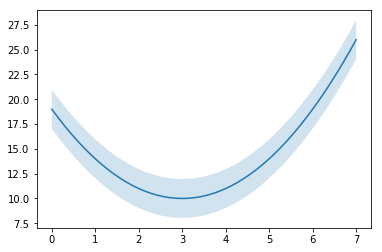

In [50]:
x = np.linspace(0, 7, 50, endpoint=True)
fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.fill_between(x, f(x)-1.96*1, f(x)+1.96*1, alpha=0.2)

# Sherpa GPyOpt with n=1

In [33]:
algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)
study = sherpa.Study(parameters=[sherpa.Continuous('x', [1,6])],
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)
for trial in study:
    print(trial.parameters['x'])
    study.add_observation(trial, objective=f(trial.parameters['x'], sd=2), iteration=1)
    study.finalize(trial)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method


2.3518347190332762
2.5454422062198585
5.6595848345032085
2.6089727558438436


INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5451718530022265


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5445232895813943


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.554664923622075


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5618179778365


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5509901315347094


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.555093238915462


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5289918323077343


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5102737418512215


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5451499519466196
2.571013403227046


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.575823013434891


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5413789766251513


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.54565714264539
3.389206067675339

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



3.2752529942876927


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5541383673761078


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.388621066424826


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


1.0009584752829828


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.275259987564149
3.1474982238030615


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.2752529305602307
3.007701821287944


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5279804876491414


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5452586834801987


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.54527817633469


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5277277139715406


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5365261699484423


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.535899124854516


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.537325125383078


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.306966430052153


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.3158017773518624


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.2720433731851326


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.306931347075573


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5420402064995087


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5451486313000373


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.5000737495756415


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.542205056301907


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


4.54705468356515


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


1.6948548824802396


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5423551283749997
2.6049111636223707

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



2.6000878571782433
2.601480261054158


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5966743027827315
2.5979773182510266


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5967717108720034
2.5890058862938212


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5908216692055763


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5918664891403878
2.5895073554542907

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



2.5930611268663926
2.5969331319964897

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



2.597406493201814


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5424752535236155


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.545193111666687


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.599510341600378


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5451891619373623


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6017106671433927


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.604416876761821


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5283126748435087


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.588450824785818


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5899619048813958


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5930348974562296


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5959348632140373


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.597726787110133


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5999563946434203


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.601124845523869


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6030530407391383


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.545197961463105


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5992657723318118


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.599607574851461


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6008700286720767


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5987076070570647


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.598843635559519


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6006225317711404


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.60227241068225


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.602265537910974


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.602246675751371


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.603772317013965


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6047324618741188


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6061710336058814


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6065558181985597


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6064134117499718


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.604557059838992


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.605974586660095


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6071436831052455


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.608424969803317


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.608769676419308


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.6098957911543983


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.607985853826331


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5267535155396845


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5456193513836527


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.648520693346308


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.648756750105656


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.65202756058685
2.643608395700355


In [34]:
study.get_best_result()

{'Iteration': 1,
 'Objective': 3.7199474673625144,
 'Trial-ID': 63,
 'x': 2.604416876761821}

In [35]:
study.results.loc[np.argmin((study.results.x - 3.)**2),:]

Trial-ID               26
Status       INTERMEDIATE
Iteration               1
x                  3.0077
Objective         14.1675
Name: 50, dtype: object

# Sherpa GPyOpt with n=5

In [36]:
algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=20)
study = sherpa.Study(parameters=[sherpa.Continuous('x', [1,6])],
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)
for trial in study:
    print(trial.parameters['x'])
    study.add_observation(trial, objective=np.mean([f(trial.parameters['x'], sd=2) for _ in range(5)]), iteration=1)
    study.finalize(trial)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


3.238486672690259
5.125046762465451
2.07157404418954
1.0


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.5123335097329345


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.661534989806683
2.4183967934719397


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method


2.442684186379991
2.4770756176971993


INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.474995342131845
2.45418689028315


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.4605760416564153
2.4614926416614296

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



2.469538806840604


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.473755299251603
2.477141128793253

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



2.4678555211280777


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.469478296602825
2.471657844371486


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


2.4733311275089003


In [37]:
study.get_best_result()

{'Iteration': 1,
 'Objective': 8.338839591678575,
 'Trial-ID': 16,
 'x': 2.477141128793253}

In [38]:
study.results.loc[np.argmin((study.results.x - 3.)**2),:]

Trial-ID                1
Status       INTERMEDIATE
Iteration               1
x                 3.23849
Objective         11.6269
Name: 0, dtype: object

# GPyOpt with n=1 (no noise)

In [41]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [123]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=0),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [124]:
# Run the optimization
max_iter = 100     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


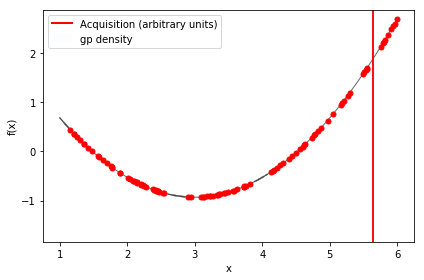

In [125]:
myBopt.plot_acquisition()

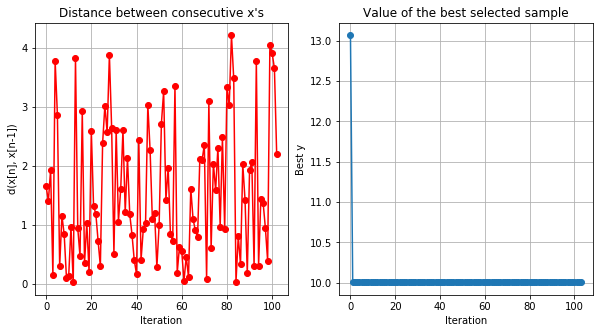

In [126]:
myBopt.plot_convergence()

In [127]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[2.94508403]


In [128]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx], " Y=", Ymean[idx])

X= [2.94508403]  Y= [-0.92919111]


# GPyOpt with n=1 (sd=1)

In [129]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [130]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=1),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [131]:
# Run the optimization
max_iter = 100     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


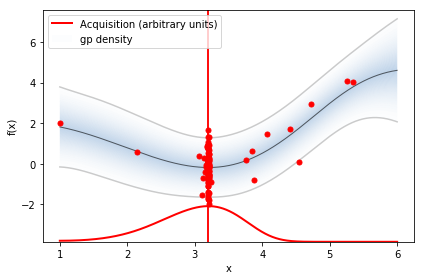

In [132]:
myBopt.plot_acquisition()

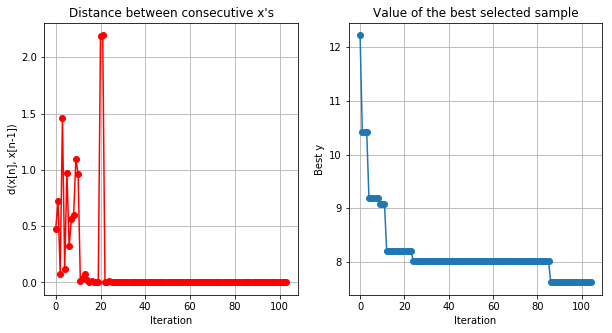

In [133]:
myBopt.plot_convergence()

In [134]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[3.20731052]


In [135]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx], " Y=", Ymean[idx])

X= [3.20214165]  Y= [-0.17998827]


# Sherpa GPyOpt with n=5

In [136]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [151]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: np.mean([f(x, sd=1) for _ in range(50)]),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [152]:
# Run the optimization
max_iter = 100     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


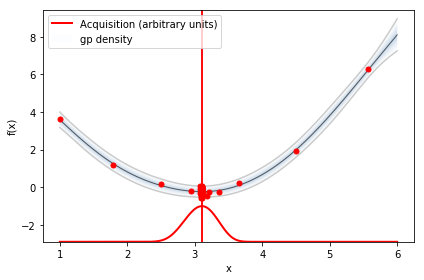

In [153]:
myBopt.plot_acquisition()

In [154]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[3.10376132]


In [155]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx], " Y=", Ymean[idx])

X= [3.10536729]  Y= [-0.23904452]


In [156]:
# Ymean, Yvar = myBopt.model.model.predict(X)
# fig, ax = plt.subplots()
# idxs = np.argsort(np.squeeze(X))
# ax.plot(X[idxs], Ymean[idxs])

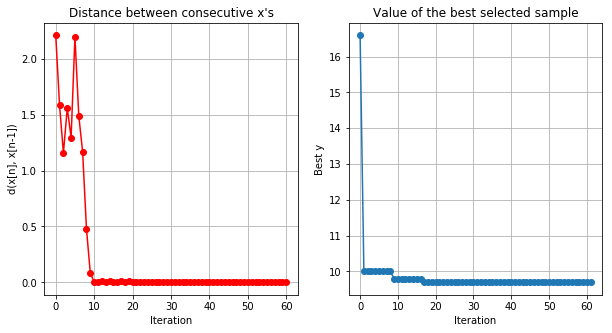

In [157]:
myBopt.plot_convergence()